# Modelamiento
---

In [491]:
# Importamos paquetes
import numpy as np
import random
import pandas as pd
import verde as vd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import halfnorm
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
import joblib
sns.set_theme()
random_state = 123

In [679]:
import sys
sys.path.append('/home/mofoko/Documents/Metodologias/tdsp_template/src')
from nombre_paquete.database import data_loader
from nombre_paquete.visualization import plotting
from nombre_paquete.models import model_loader
from nombre_paquete.evaluation import eval_loader
from nombre_paquete.models import model_search


In [680]:
import importlib
# Make changes to the module's code
# Reload the module
importlib.reload(data_loader)
importlib.reload(plotting)
importlib.reload(model_loader)
importlib.reload(eval_loader)
importlib.reload(model_search)

<module 'nombre_paquete.models.model_search' from '/home/mofoko/Documents/Metodologias/tdsp_template/src/nombre_paquete/models/model_search.py'>

## Selección de características
---

In [4]:
# Definimos las variables categoricas
categorical = ['A_dom', 'A_reg', 'A_cont'] 
# Definimos las variables numericas
numeric = ['elevation', 'sedthick']
target = 'q'
# Features extraidas
features = ['knn', 'G', 'F', 'J', 'K', 'L']
# Variables geoespaciales
coords = ['lat', 'lng']
temporal = 'A_year'

In [5]:
db12_prep = data_loader.load_data_feat()
db12_prep

,q,lat,lng,elevation,A_dom,A_reg,A_cont,A_year,sedthick,knn,G,F,J,K,L
0,201.0,-16.0733,-17.2717,-3855.9,marine,South Atlantic Ocean,South American Plate,2008,85.999977,0.0000,0.200705,0.000000,0.799295,0.239940,0.292253
1,214.0,-16.0733,-17.2717,-3855.9,marine,South Atlantic Ocean,South American Plate,2008,85.999977,0.0000,0.202756,0.000033,0.797244,1.106536,0.300442
2,46.0,-0.9917,81.3983,-4720.3,marine,Indian Ocean,Indo-Australian Plate,2008,1756.000000,0.0000,0.204807,0.000065,0.795193,1.973131,0.308631
3,57.0,-0.9917,81.3983,-4720.3,marine,Indian Ocean,Indo-Australian Plate,2008,1756.000000,0.0000,0.206858,0.000098,0.793142,2.839727,0.316820
4,176.0,-39.9900,-109.8550,-3194.4,marine,South Pacific Ocean,Antarctic Plate,2008,17.999983,0.0000,0.208909,0.000131,0.791091,3.706322,0.325009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30926,19.0,24.9000,122.7000,-1542.0,marine,East China Sea,Eurasian Plate - Asia,2019,1872.397949,0.0183,1.000000,0.960000,0.000000,14785.913267,-334.130187
30927,8.0,24.9200,122.7000,-1464.0,marine,East China Sea,Eurasian Plate - Asia,2019,1872.397949,0.0200,1.000000,0.960000,0.000000,14785.913267,-334.143191
30928,12.0,24.9400,122.7000,-1478.0,marine,East China Sea,Eurasian Plate - Asia,2019,1872.397949,0.0200,1.000000,0.960000,0.000000,14785.913267,-334.156196
30929,54.0,24.9600,122.7000,-1462.0,marine,East China Sea,Eurasian Plate - Asia,2019,2009.021484,0.0200,1.000000,0.960000,0.000000,14785.913267,-334.169200


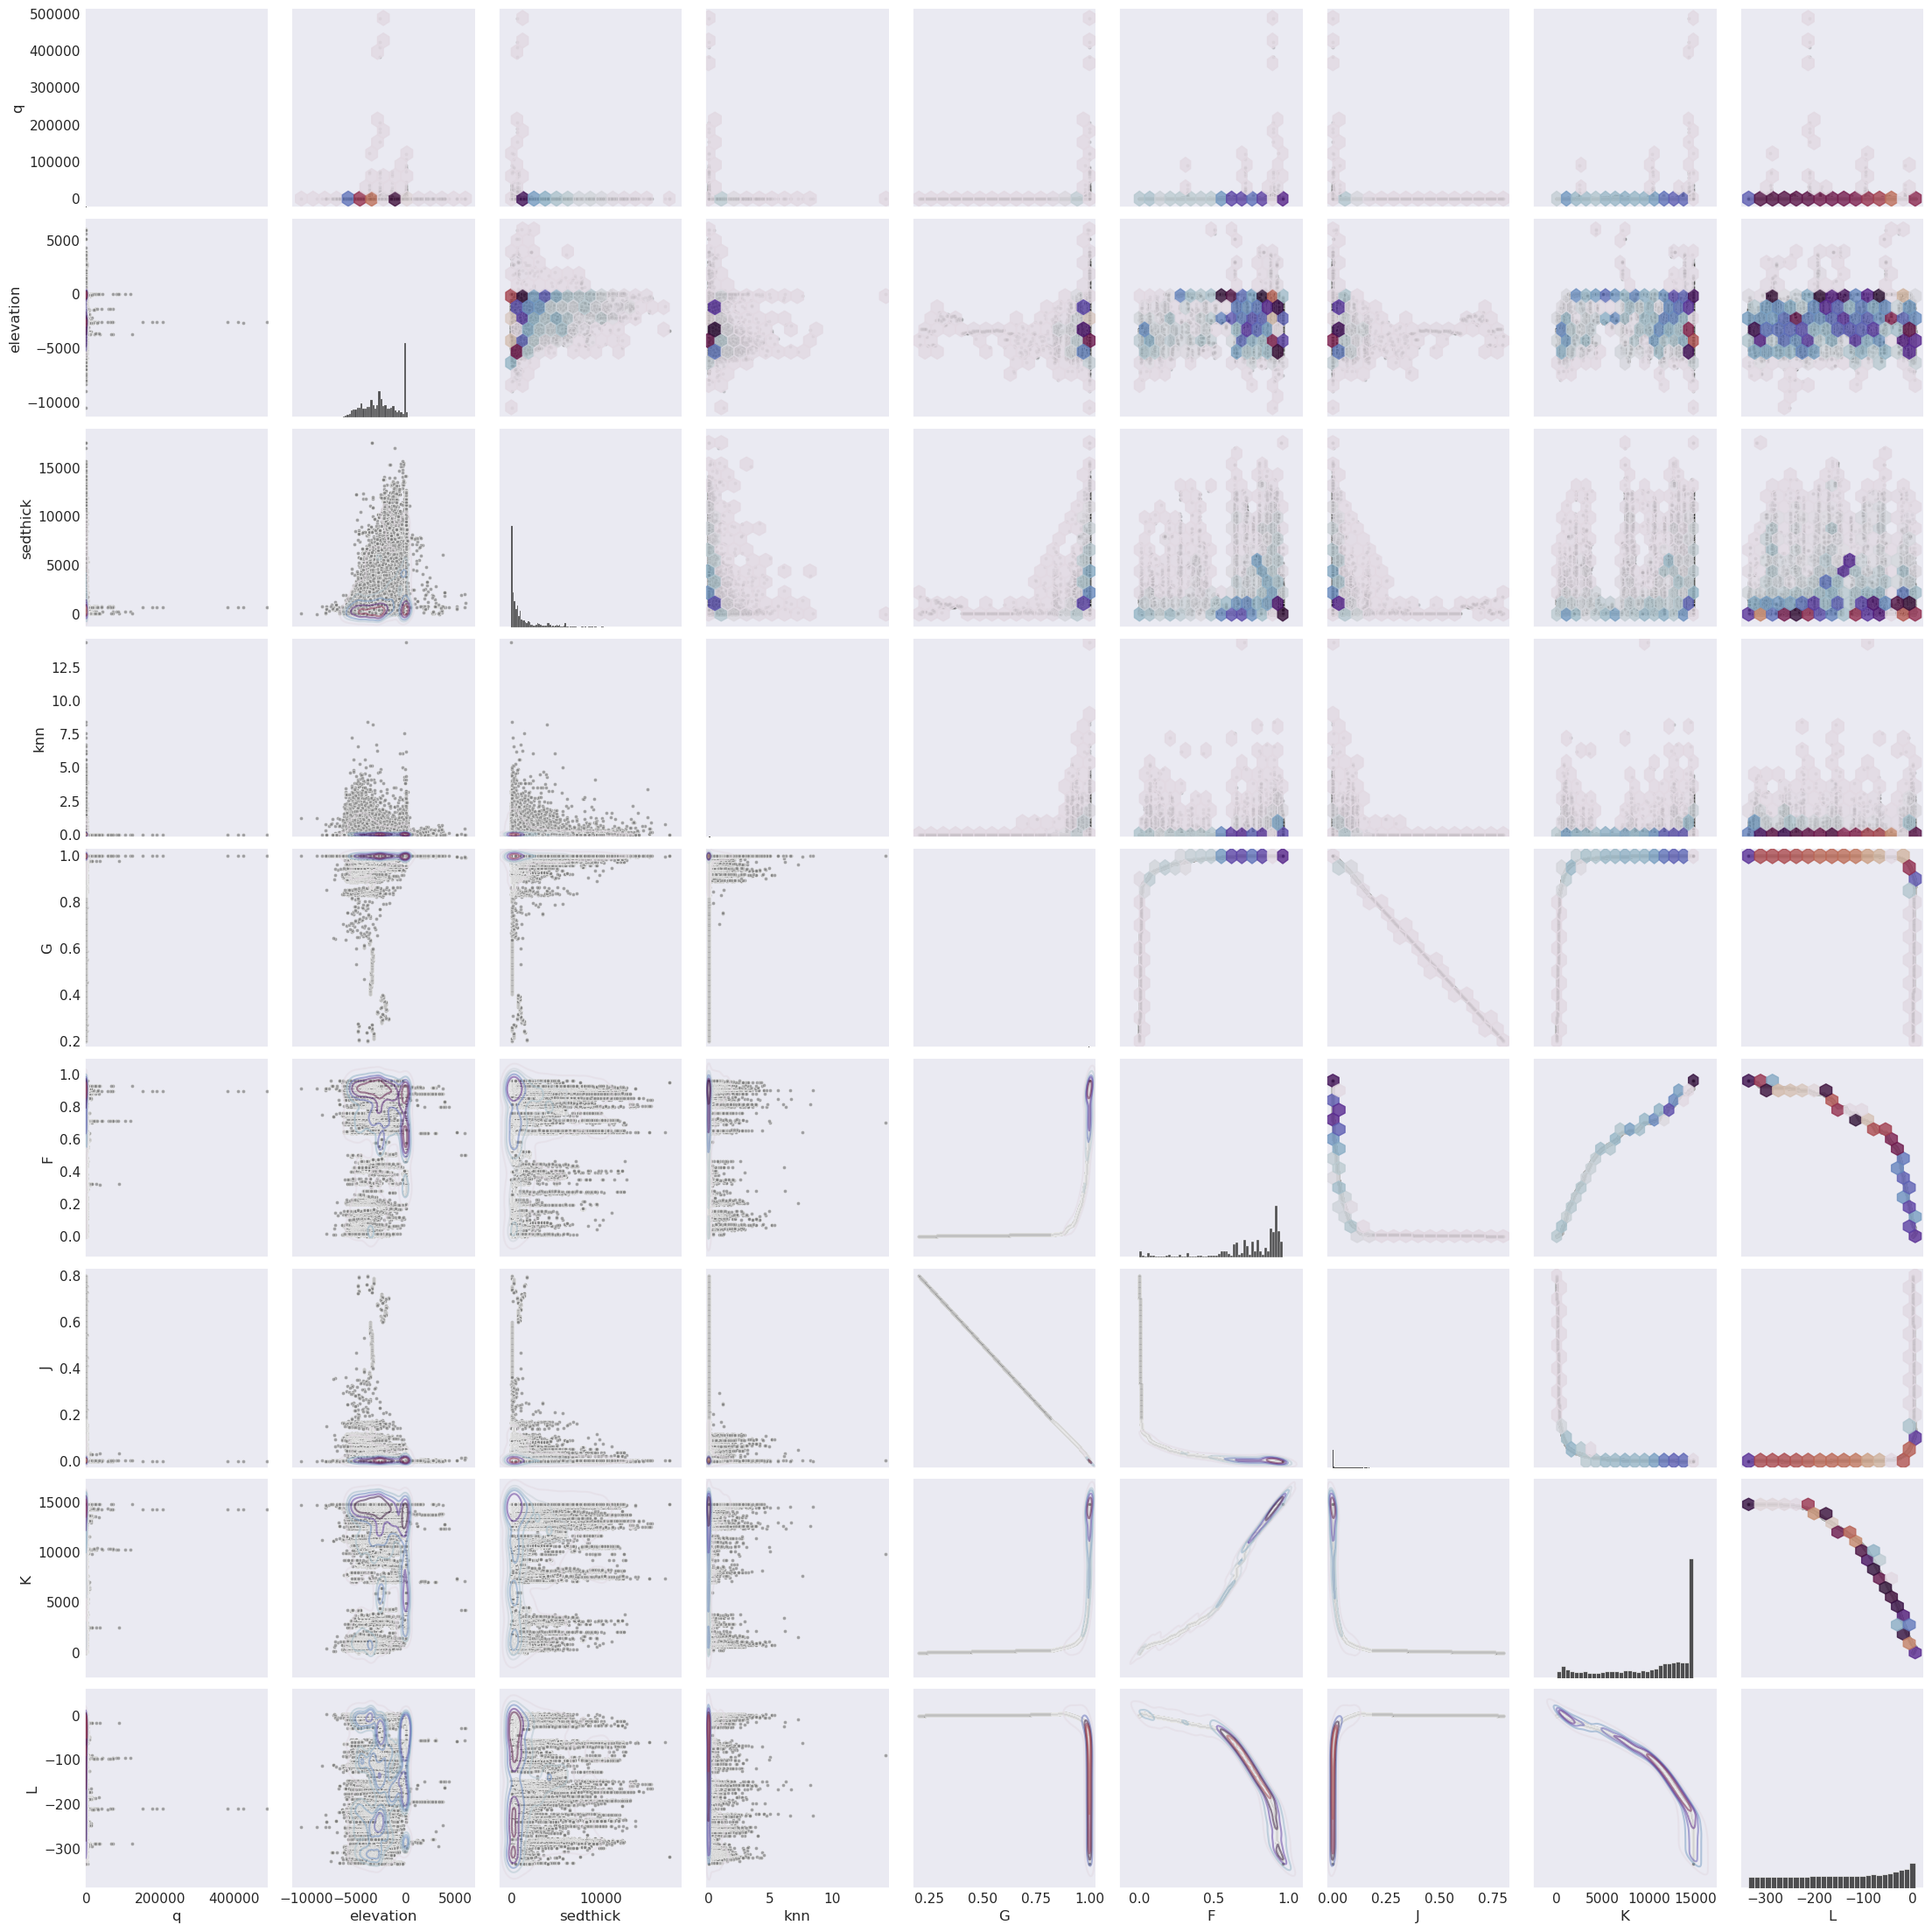

In [115]:
plotting.kde_hexbin_pairplot(db12_prep[numeric + features])

## Spatial Train test split
---
Usualmente se tiende a particionar aleatoriamente el conjunto de datos, sin embargo, este tipo de partición no tienen en cuenta su posición en el espacio. Esto puede ser problemático si los datos están autocorrelacionados espacialmente, es decir, si los valores cercanos espacialmente tienden a ser similares. En tales casos, la división aleatoria puede llevar a una sobreestimación de la calidad de la predicción de los modelos.

Como alternativa, se puede realizar una división en bloques espaciales. En este enfoque, los datos se agrupan en bloques de un tamaño específico y luego se divide aleatoriamente entre los conjuntos de entrenamiento y prueba. Esto tiene en cuenta la estructura espacial de los datos y puede proporcionar una división más adecuada en situaciones donde la autocorrelación espacial es relevante.

In [6]:
# Features y target
features + [numeric[1], target]

['knn', 'G', 'F', 'J', 'K', 'L', 'sedthick', 'q']

Debido a que los datos presentan autocorrelación espacial es necesario hacer un split en bloques spaciales.

In [700]:
# Dividiendo las coordenadas y los valores en tuplas separadas
coordinates = tuple(db12_prep[col].to_numpy() for col in coords)
values = tuple(db12_prep[col].to_numpy() for col in features + [numeric[1], target])
# Block size
block_size = 10
# Realizando una división en bloques de entrenamiento, validación-prueba
train, val_test = vd.train_test_split(coordinates, values, test_size=.3, spacing=block_size, random_state=random_state)
coord_train, data_train, w_train  = train
coord_val_test, data_val_test, w_val_test  = val_test
# Dividiendo en bloques la parte de validación y prueba en conjuntos separados
val, test = vd.train_test_split(coord_val_test, data_val_test, test_size=.5, spacing=10, random_state=random_state)
coord_val, data_val, w_val  = val
coord_test, data_test, w_test  = test
# Obteniendo los datos de entrenamiento, validación y prueba
X_train, y_train = data_train[:-1], data_train[-1]
X_val, y_val = data_val[:-1], data_val[-1]
X_test, y_test = data_test[:-1], data_test[-1]

In [684]:
print(f'train size:{len(y_train)}')
print(f'validation size :{len(y_val)}')
print(f'test size :{len(y_test)}')

train size:21879
validation size :4476
test size :4576


/home/mofoko/anaconda3/envs/oceanenv/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1700: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  result = super().scatter(*args, **kwargs)


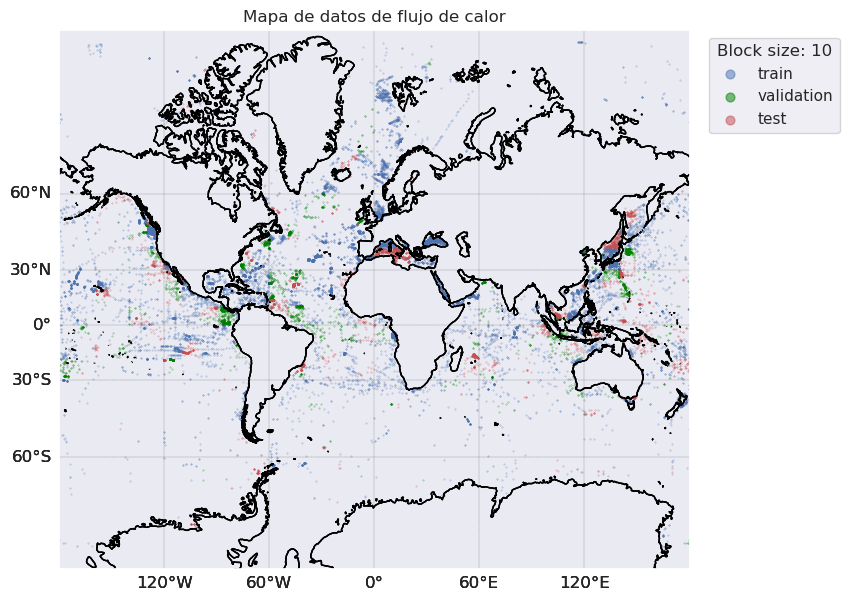

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [685]:
df_test = pd.DataFrame({'lat': coord_test[0],
                         'lng': coord_test[1],
                         'q': y_test
                         })
df_val = pd.DataFrame({'lat': coord_val[0],
                         'lng': coord_val[1],
                         'q': y_val
                         })
df_train = pd.DataFrame({'lat': coord_train[0],
                         'lng': coord_train[1],
                         'q': y_train
                         })
epsg_code = 3395
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.epsg(epsg_code))
plotting.plot_map(df_train, c='b', ax=ax, label='train')
plotting.plot_map(df_val, c='green', ax=ax, label='validation')
plotting.plot_map(df_test, c='r', ax=ax, label='test')
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1), markerscale=20).set_title(f'Block size: {block_size}')

## Modelo Baseline
---

In [701]:
RANSAC = model_loader.polyRegressionRANSAC(degree=3)
RANSAC = RANSAC.fit(pd.Series(X_train[-1]), y_train)
y_pred_val = RANSAC.predict(X_val[-1].reshape(-1, 1))

Text(0, 0.5, 'Flujo de calor log($[mW/m^2]$)')

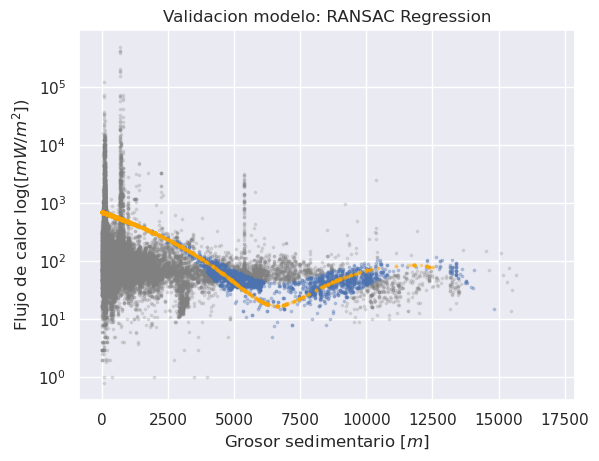

In [703]:
inlier_mask = RANSAC.inlier_mask_
idx_sed = -1
plt.scatter(X_train[idx_sed][~inlier_mask], y_train[~inlier_mask], color='gray', marker='.', alpha=0.2,
            label='RANSAC outliers', s=12)
plt.scatter(X_train[idx_sed][inlier_mask], y_train[inlier_mask], color='b', marker='.', alpha=0.3,
            label='RANSAC inliers', s=12)
plt.scatter(X_val[idx_sed], y_pred_val, color='orange', marker='.', alpha=0.3,
         label='RANSAC cubic', s=12)

plt.yscale('log')
plt.title('Validacion modelo: RANSAC Regression')
plt.xlabel(r'Grosor sedimentario $[m]$')
plt.ylabel(r'Flujo de calor log($[mW/m^2]$)')

In [590]:
y_pred_test = RANSAC.predict(X_test[-1].reshape(-1, 1))
eval_loader.eval_regres(y_pred_test, y_test)

,MSE,MAE,R2
0,1.091069e+07,511.106331,-0.000738


## Modelo 1
---
En esta sección del notebook, presentaremos el primer modelo implementado, que es un SVR (Support Vector Regression). En nuestro escenario, hemos utilizado un conjunto de datos que contiene información geoespacial y características relacionadas con el grosor sedimentario y el flujo de calor. El objetivo principal es predecir un valor de flujo de calor, basado en estas características espaciales y el grosor sedimentario, utilizando el enfoque de regresión.

El SVR es una variante del algoritmo de Support Vector Machines (SVM) adaptado para tareas de regresión. A diferencia de los métodos de regresión lineal tradicionales, el SVR puede manejar tanto relaciones lineales como no lineales entre las características y el objetivo. Esto lo logra mediante el uso de funciones de kernel para mapear los datos a un espacio de mayor dimensión, donde se encuentra más fácilmente una relación lineal.

En nuestro caso, hemos seleccionado siete características para alimentar el modelo SVR. Estas características incluyen el grosor sedimentario y otras seis características de tipo espacial (knn, G, F, J, K, L) que hemos considerado relevantes para nuestro problema. Al proporcionar estas características al modelo, esperamos que el SVR aprenda a mapear las entradas a un valor continuo que represente el objetivo deseado.

In [694]:
# Convert the tuple to a matrix and transpose it
X_train_matrix = np.vstack(X_train)
X_train_matrix_T = np.transpose(X_train_matrix)
X_val_matrix = np.vstack(X_val)
X_val_matrix_T = np.transpose(X_val_matrix)
X_test_matrix = np.vstack(X_test)
X_test_matrix_T = np.transpose(X_test_matrix)

In [695]:
# Create and train the SVR model
svr = SVR(kernel='rbf')
svr.fit(X_train_matrix_T, y_train)
# Make predictions on the test set
y_pred_val = svr.predict(X_val_matrix_T)

Text(0, 0.5, 'Flujo de calor log($[mW/m^2]$)')

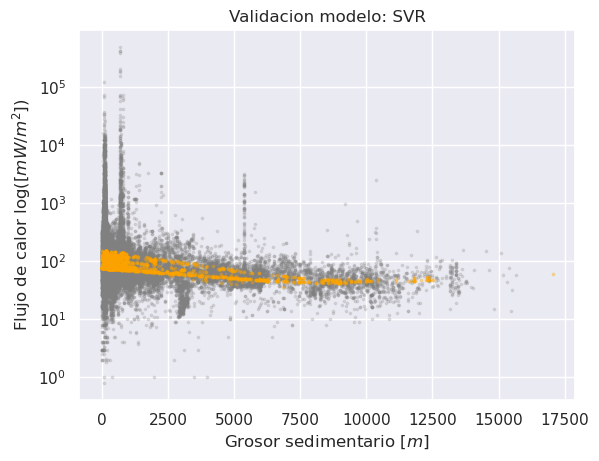

In [698]:
idx_sed = -1
plt.scatter(X_train[idx_sed], y_train, color='gray', marker='.', alpha=0.2,
            label='RANSAC outliers', s=12)
plt.scatter(X_val[idx_sed], y_pred_val, color='orange', marker='.', alpha=0.3,
         label='RANSAC cubic', s=12)
plt.yscale('log')
plt.title('Validacion modelo: SVR')
plt.xlabel(r'Grosor sedimentario $[m]$')
plt.ylabel(r'Flujo de calor log($[mW/m^2]$)')

In [697]:
y_pred_test = svr.predict(X_test_matrix_T)
eval_loader.eval_regres(y_pred_test, y_test)

,MSE,MAE,R2
0,1.092930e+07,234.382312,-0.002445


## Validación cruzada por bloques
---

In [681]:
# Dividiendo las coordenadas y los valores en tuplas separadas
coordinates = tuple(db12_prep[col].to_numpy() for col in coords)
values = tuple(db12_prep[col].to_numpy() for col in features + [numeric[1], target])
# Block size
block_size = 20
# Realizando una división en bloques de entrenamiento, validación-prueba
train_val, test = vd.train_test_split(coordinates, values, test_size=.15, spacing=block_size, random_state=random_state)
coord_train_val, data_train_val, w_train_val  = train_val
coord_test, data_test, w_test  = test

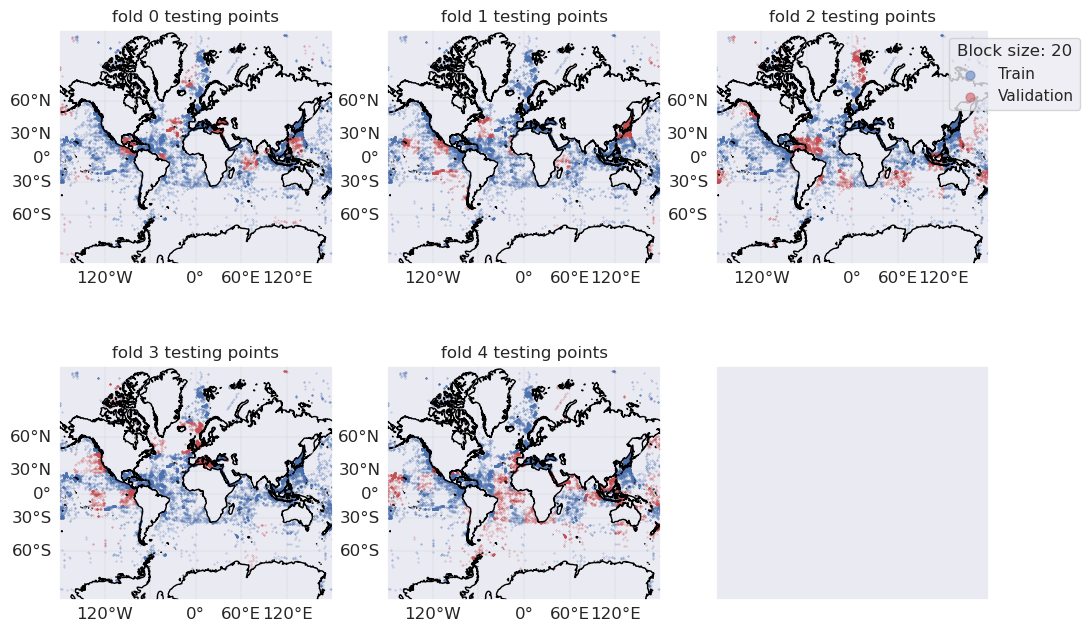

In [682]:
df_train_val = model_loader.datasplit_in_DB(db12_prep, data_train_val, features + [numeric[1], target])
kfold = vd.BlockKFold(spacing=block_size, shuffle=True, n_splits=5, random_state=random_state)
folds = kfold.split(np.transpose(coord_train_val))
plotting.kfold_map(folds, df_train_val, block_size=block_size)

In [630]:
blocksizes = sorted([round(random.uniform(0.1, 100),1) for _ in range(10)])
n_splits = 5
df_CV = model_search.BlockKFold_search(blocksizes,
                                       n_splits,
                                       SVR(kernel='rbf'),
                                       db12_prep,
                                       features + [numeric[1]],
                                       target,
                                       coord_train_val,
                                       data_train_val,
                                       random_state=random_state,
                                       )

Block 0:   0%|          | 0/5 [00:00<?, ?fold/s]

Block 1:   0%|          | 0/5 [00:00<?, ?fold/s]

Block 2:   0%|          | 0/5 [00:00<?, ?fold/s]

Block 3:   0%|          | 0/5 [00:00<?, ?fold/s]

Block 4:   0%|          | 0/5 [00:00<?, ?fold/s]

Block 5:   0%|          | 0/5 [00:00<?, ?fold/s]

Block 6:   0%|          | 0/5 [00:00<?, ?fold/s]

Block 7:   0%|          | 0/5 [00:00<?, ?fold/s]

Block 8:   0%|          | 0/5 [00:00<?, ?fold/s]

Block 9:   0%|          | 0/5 [00:00<?, ?fold/s]

In [631]:
df_CV

,block,fold,MSE,MAE,R2
0,16.1,1.0,7.011868e+06,349.250019,-0.015087
1,16.1,2.0,2.420395e+06,113.523107,0.000545
2,16.1,3.0,4.317233e+06,173.106795,-0.002953
3,16.1,4.0,1.358217e+08,933.024116,-0.006261
4,41.9,0.0,2.174300e+08,1105.716757,-0.005536
5,41.9,1.0,2.568734e+06,504.130322,-0.103918
6,41.9,2.0,4.076600e+06,149.184683,-0.001997
7,41.9,3.0,2.761269e+06,195.013496,-0.006723
8,41.9,4.0,3.046600e+04,62.579804,-0.050799
9,44.7,0.0,3.109819e+06,606.976646,-0.129887


In [633]:
df_CV_mean = df_CV.groupby('block').mean()
df_CV_mean

,fold,MSE,MAE,R2
block,,,,
16.1,2.5,3.739279e+07,392.226009,-0.005939
41.9,2.0,4.537341e+07,403.325012,-0.033795
44.7,2.0,3.173722e+07,352.855503,-0.035503
45.2,2.0,3.173722e+07,352.855503,-0.035503
46.2,2.0,3.173722e+07,352.855503,-0.035503
49.9,2.0,4.234342e+07,383.724335,-0.036324
64.3,2.0,2.766597e+07,311.111671,-0.007511
76.0,2.0,2.428015e+07,272.479317,-0.013452
83.6,2.0,2.620267e+07,277.809359,-0.015605


0
1
2


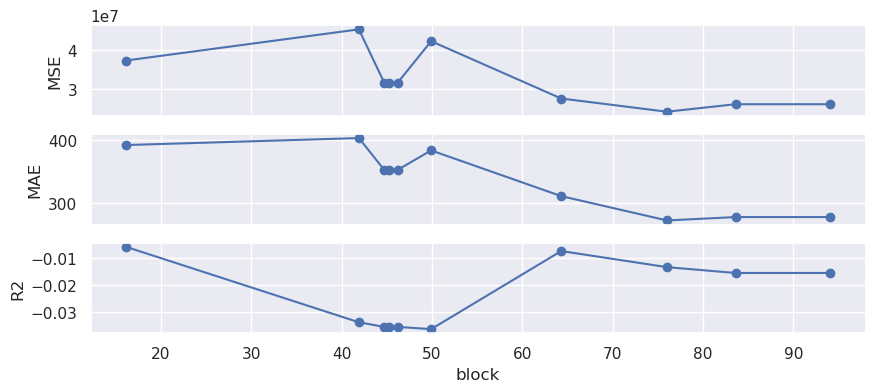

In [660]:
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 4))
list_metrics = ['MSE', 'MAE', 'R2']
for i, (ax, metric) in enumerate(zip(axes, list_metrics)):
    df_CV_mean[metric].plot(marker='o', ax=ax)
    ax.set_ylabel(metric)
    print(i)
    if i+1 < len(list_metrics):
        ax.set_xticklabels([])

In [710]:
id_min_MAE = df_CV_mean['MAE'].argmin()
block_size_optim = df_CV_mean.index[id_min_MAE]
print(f'El block size más optimo para el modelo es: {block_size_optim}')

El block size más optimo para el modelo es: 76.0


In [704]:
# Dividiendo las coordenadas y los valores en tuplas separadas
coordinates = tuple(db12_prep[col].to_numpy() for col in coords)
values = tuple(db12_prep[col].to_numpy() for col in features + [numeric[1], target])
# Block size
block_size = block_size_optim
# Realizando una división en bloques de entrenamiento, validación-prueba
train, val_test = vd.train_test_split(coordinates, values, test_size=.3, spacing=block_size, random_state=random_state)
coord_train, data_train, w_train  = train
coord_val_test, data_val_test, w_val_test  = val_test
# Dividiendo en bloques la parte de validación y prueba en conjuntos separados
val, test = vd.train_test_split(coord_val_test, data_val_test, test_size=.5, spacing=10, random_state=random_state)
coord_val, data_val, w_val  = val
coord_test, data_test, w_test  = test
# Obteniendo los datos de entrenamiento, validación y prueba
X_train, y_train = data_train[:-1], data_train[-1]
X_val, y_val = data_val[:-1], data_val[-1]
X_test, y_test = data_test[:-1], data_test[-1]

/home/mofoko/anaconda3/envs/oceanenv/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1700: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  result = super().scatter(*args, **kwargs)


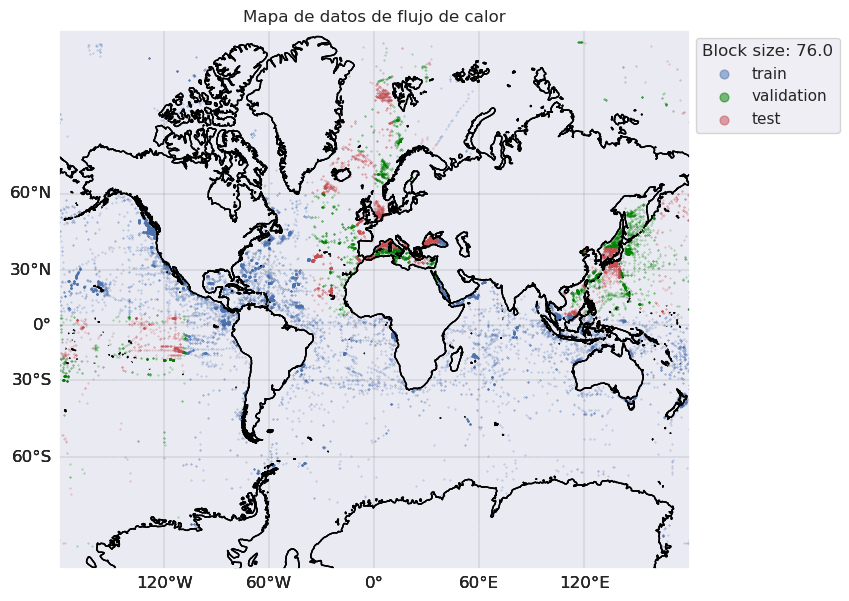

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [705]:
df_test = pd.DataFrame({'lat': coord_test[0],
                         'lng': coord_test[1],
                         'q': y_test
                         })
df_val = pd.DataFrame({'lat': coord_val[0],
                         'lng': coord_val[1],
                         'q': y_val
                         })
df_train = pd.DataFrame({'lat': coord_train[0],
                         'lng': coord_train[1],
                         'q': y_train
                         })
epsg_code = 3395
fig = plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.epsg(epsg_code))
plotting.plot_map(df_train, c='b', ax=ax, label='train')
plotting.plot_map(df_val, c='green', ax=ax, label='validation')
plotting.plot_map(df_test, c='r', ax=ax, label='test')
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1), markerscale=20).set_title(f'Block size: {block_size_optim}')

In [706]:
# Convert the tuple to a matrix and transpose it
X_train_matrix = np.vstack(X_train)
X_train_matrix_T = np.transpose(X_train_matrix)
X_val_matrix = np.vstack(X_val)
X_val_matrix_T = np.transpose(X_val_matrix)
X_test_matrix = np.vstack(X_test)
X_test_matrix_T = np.transpose(X_test_matrix)

In [707]:
# Create and train the SVR model
svr = SVR(kernel='rbf',)
model_1 = svr.fit(X_train_matrix_T, y_train)
# Make predictions on the test set
y_pred_val = svr.predict(X_val_matrix_T)

Text(0, 0.5, 'Flujo de calor log($[mW/m^2]$)')

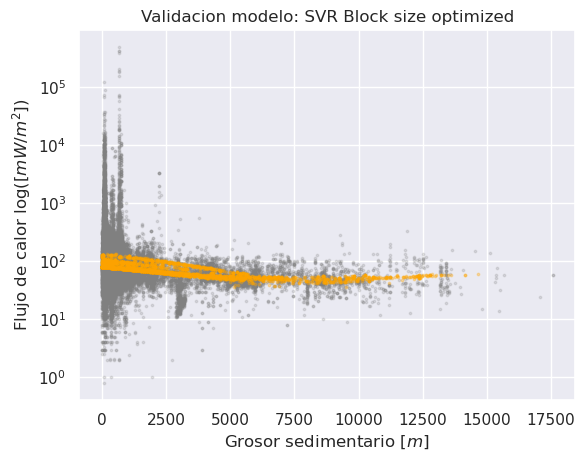

In [708]:
idx_sed = -1
plt.scatter(X_train[idx_sed], y_train, color='gray', marker='.', alpha=0.2,
            label='RANSAC outliers', s=12)
plt.scatter(X_val[idx_sed], y_pred_val, color='orange', marker='.', alpha=0.3,
         label='RANSAC cubic', s=12)
plt.yscale('log')
plt.title('Validacion modelo: SVR Block size optimized')
plt.xlabel(r'Grosor sedimentario $[m]$')
plt.ylabel(r'Flujo de calor log($[mW/m^2]$)')

In [709]:
y_pred_test = svr.predict(X_test_matrix_T)
eval_loader.eval_regres(y_pred_test, y_test)

,MSE,MAE,R2
0,22238.741548,45.430096,0.011897


In [692]:
model_path = '/home/mofoko/Documents/Metodologias/tdsp_template/src/nombre_paquete/models/'
joblib.dump(model_1, model_path+'model.joblib')


['/home/mofoko/Documents/Metodologias/tdsp_template/src/nombre_paquete/models/model.joblib']

In [712]:
import os
# Establece las rutas de origen y destino para el archivo que se va a mover
os.environ['source'] = "/home/mofoko/Documents/Metodologias/tdsp_template/src/nombre_paquete/models/model.joblib"
os.environ['dest'] = "/home/mofoko/Documents/Metodologias/tdsp_template/src/nombre_paquete/deployment/model.joblib"
# Mueve el archivo desde la ruta de origen a la ruta de destino
!cp $source $dest 